# 쇼핑몰 지점별 매출액 예측 경진대회

## 데이터 불러오기

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm import tqdm

warnings.filterwarnings('ignore')

In [2]:
sns.set_theme(style='white')

In [3]:
os.getcwd()

'C:\\Users\\Jaesu\\github_desktop\\Dacon-Basic\\쇼핑몰지점별-매출액-예측\\쇼핑몰지점별-매출액-EDA모델링'

In [4]:
os.chdir('C:\\Users\\Jaesu\\github_desktop\\Dacon-Basic\\쇼핑몰지점별-매출액-예측')

In [5]:
df = pd.read_csv('./Data/train.csv')
test = pd.read_csv('./Data/test.csv')
submission = pd.read_csv('./Data/sample_submission.csv')

|변수 이름|세부 사항|
|:-:|:-:|
|id | 샘플 아이디|
|Store | 쇼핑몰 지점|
|Date | 주 단위(Weekly) 날짜|
|Temperature | 해당 쇼핑몰 주변 기온|
|Fuel_Price | 해당 쇼핑몰 주변 연료 가격|
|Promotion 1~5 | 해당 쇼핑몰의 비식별화된 프로모션 정보|
|Unemployment | 해당 쇼핑몰 지역의 실업률|
|IsHoliday | 해당 기간의 공휴일 포함 여부|
|Weekly_Sales | 주간 매출액 (목표 예측값)|

In [6]:
df.shape, test.shape

((6255, 13), (180, 12))

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6255 entries, 0 to 6254
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            6255 non-null   int64  
 1   Store         6255 non-null   int64  
 2   Date          6255 non-null   object 
 3   Temperature   6255 non-null   float64
 4   Fuel_Price    6255 non-null   float64
 5   Promotion1    2102 non-null   float64
 6   Promotion2    1592 non-null   float64
 7   Promotion3    1885 non-null   float64
 8   Promotion4    1819 non-null   float64
 9   Promotion5    2115 non-null   float64
 10  Unemployment  6255 non-null   float64
 11  IsHoliday     6255 non-null   bool   
 12  Weekly_Sales  6255 non-null   float64
dtypes: bool(1), float64(9), int64(2), object(1)
memory usage: 592.6+ KB


In [8]:
df.isnull().sum()

id                 0
Store              0
Date               0
Temperature        0
Fuel_Price         0
Promotion1      4153
Promotion2      4663
Promotion3      4370
Promotion4      4436
Promotion5      4140
Unemployment       0
IsHoliday          0
Weekly_Sales       0
dtype: int64

`-` 프로모션 변수들에 결측치가 많이 존재한다

`-` id는 무의미한 변수이므로 제거한다

In [6]:
df.drop('id', axis=1, inplace=True)
test.drop('id', axis=1, inplace=True)

In [10]:
df.head()

,Store,Date,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,Unemployment,IsHoliday,Weekly_Sales
0,1,05/02/2010,42.31,2.572,NaN,NaN,NaN,NaN,NaN,8.106,False,1643690.90
1,1,12/02/2010,38.51,2.548,NaN,NaN,NaN,NaN,NaN,8.106,True,1641957.44
2,1,19/02/2010,39.93,2.514,NaN,NaN,NaN,NaN,NaN,8.106,False,1611968.17
3,1,26/02/2010,46.63,2.561,NaN,NaN,NaN,NaN,NaN,8.106,False,1409727.59
4,1,05/03/2010,46.50,2.625,NaN,NaN,NaN,NaN,NaN,8.106,False,1554806.68


In [11]:
df.describe()

,Store,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,Unemployment,Weekly_Sales
count,6255.000000,6255.000000,6255.000000,2102.000000,1592.000000,1885.000000,1819.000000,2115.000000,6255.000000,6.255000e+03
mean,23.000000,60.639199,3.344369,7155.930661,3308.125810,1462.535523,3465.952501,4518.993173,8.029236,1.047619e+06
std,12.988211,18.624094,0.455364,8408.206085,9382.823804,9667.580258,6413.116294,6048.661908,1.874875,5.654362e+05
min,1.000000,-2.060000,2.472000,0.270000,-265.760000,-29.100000,0.410000,135.160000,4.077000,2.099862e+05
25%,12.000000,47.170000,2.917000,1844.295000,39.755000,4.700000,499.895000,1742.305000,6.916500,5.538695e+05
50%,23.000000,62.720000,3.413000,5221.140000,205.410000,24.600000,1532.630000,3226.410000,7.906000,9.604761e+05
75%,34.000000,75.220000,3.722000,9199.242500,1931.005000,104.010000,3640.905000,5444.030000,8.622000,1.421209e+06
max,45.000000,100.140000,4.308000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,14.313000,3.818686e+06


In [12]:
len(df['Store'].unique()), len(df['Date'].unique()), df.shape[0]

(45, 139, 6255)

`-` 데이터는 45개의 쇼핑몰에 대해 각기 다른 139개의 날짜에 따른 정보를 담고 있다

`-` 총 데이터의 개수는 $45\times 139=6255$ 이다

## 데이터 전처리 및 파생변수 생성

`-` Data 변수를 날짜 형식으로 변경하여 연, 월, 일 변수를 생성하겠다

`-` 또한 2010년을 기준으로 연월일을 하루 단위로 변환하여 2010년으로부터 며칠이 지났는지를 알 수 있는 변수를 생성하겠다  

In [7]:
def move_target_end(df: pd.DataFrame, target: str) -> None:
    """target column을 마지막 column으로 이동시키는 함수"""
    tmp_target = df[target]
    df.drop(target, axis=1, inplace=True)
    df[target] = tmp_target

In [8]:
def get_date(df) -> None:
    """df['Date']에서 연, 월, 일 변수를 생성""" 
    df['Date'] = pd.to_datetime(df['Date'])
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Day'] = df['Date'].dt.day

In [9]:
get_date(df)

In [10]:
df['Day_Range'] = (df['Date'] - pd.datetime(2010, 1, 1)).dt.days

In [11]:
move_target_end(df, 'Weekly_Sales')

`-` 공휴일 변수를 숫자로 바꿔주겠다

In [12]:
df['IsHoliday'] = df['IsHoliday'].apply(lambda x: 1 if x else 0)

`-` 4분기 변수와 month의 몇 번째 week인지 나타내는 변수, 주말 여부 변수를 생성하겠다 

In [13]:
df['Quarter'] = df['Date'].dt.quarter
df['WeekOfMonth'] = df['Day'].apply(lambda x: (x-1) // 7 + 1)
df['IsWeekend'] = df['Date'].dt.weekday.apply(lambda x: 1 if x >= 5 else 0)

In [14]:
move_target_end(df, 'Weekly_Sales')

In [15]:
df.head()

,Store,Date,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,Unemployment,IsHoliday,Year,Month,Day,Day_Range,Quarter,WeekOfMonth,IsWeekend,Weekly_Sales
0,1,2010-05-02,42.31,2.572,NaN,NaN,NaN,NaN,NaN,8.106,0,2010,5,2,121,2,1,1,1643690.90
1,1,2010-12-02,38.51,2.548,NaN,NaN,NaN,NaN,NaN,8.106,1,2010,12,2,335,4,1,0,1641957.44
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,8.106,0,2010,2,19,49,1,3,0,1611968.17
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,8.106,0,2010,2,26,56,1,4,0,1409727.59
4,1,2010-05-03,46.50,2.625,NaN,NaN,NaN,NaN,NaN,8.106,0,2010,5,3,122,2,1,0,1554806.68


## EDA

### 범주형 변수 시각화

- 쇼핑몰 지점

<AxesSubplot:xlabel='Store', ylabel='count'>

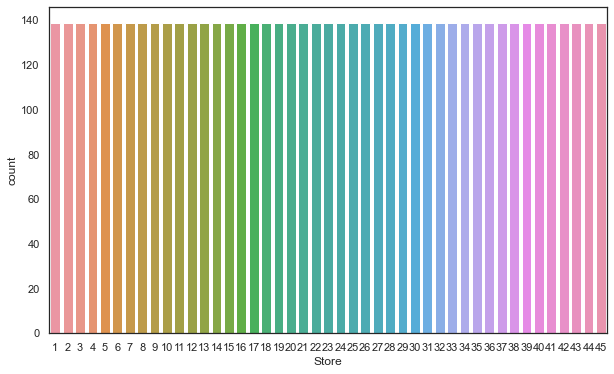

In [208]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
sns.countplot(data=df, x='Store', ax=ax)

`-` 쇼핑몰 지점은 1번부터 45번까지 139개씩 존재한다

- 공휴일

<AxesSubplot:xlabel='IsHoliday', ylabel='count'>

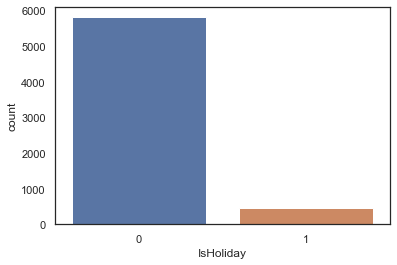

In [201]:
sns.countplot(data=df, x='IsHoliday')

`-` 공휴일인 날짜는 전체 날짜 중 대략 5%이다

- 주말

<AxesSubplot:xlabel='IsWeekend', ylabel='count'>

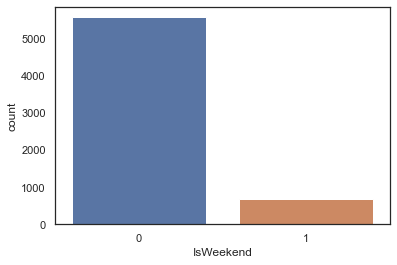

In [68]:
sns.countplot(data=df, x='IsWeekend')

`-`  주말인 날짜는 전체 날짜 중 대략 10%이다

### 양적 변수 시각화

- 주간 매출액

<AxesSubplot:xlabel='Weekly_Sales', ylabel='Count'>

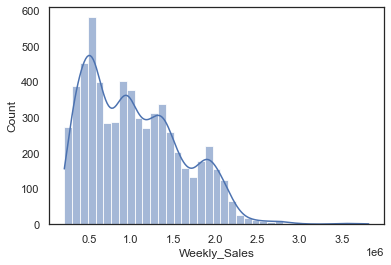

In [56]:
sns.histplot(data=df, x='Weekly_Sales', kde=True)

`-` 오른쪽으로 꼬리가 긴 분포이다

`-` 봉우리가 4개이다

<AxesSubplot:xlabel='IsHoliday', ylabel='Weekly_Sales'>

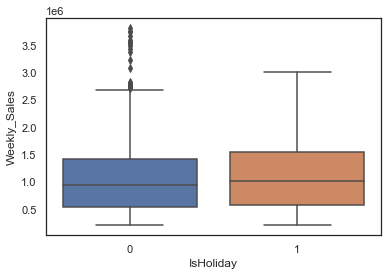

In [213]:
sns.boxplot(data=df, y='Weekly_Sales', x='IsHoliday')

`-` 공휴일에 따른 매출액의 차이는 없다

<AxesSubplot:xlabel='IsWeekend', ylabel='Weekly_Sales'>

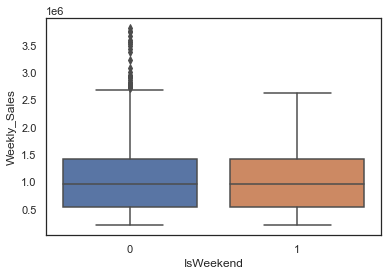

In [69]:
sns.boxplot(data=df, y='Weekly_Sales', x='IsWeekend')

`-` 주말에 따른 매출액의 차이는 없다

<AxesSubplot:xlabel='WeekOfMonth', ylabel='Weekly_Sales'>

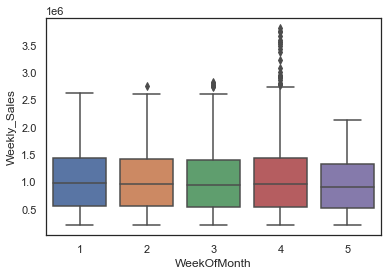

In [189]:
sns.boxplot(data=df, y='Weekly_Sales', x='WeekOfMonth')

`-` 몇 번째 week인지에 따른 매출액의 차이는 있다

<AxesSubplot:xlabel='Year', ylabel='Weekly_Sales'>

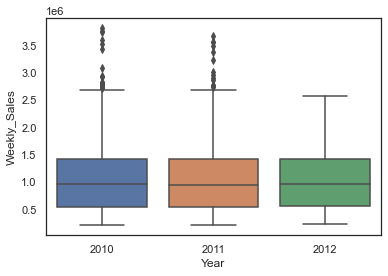

In [32]:
sns.boxplot(data=df, y='Weekly_Sales', x='Year')

`-` 연도에 따른 매출액의 차이는 없다

<AxesSubplot:xlabel='Quarter', ylabel='Weekly_Sales'>

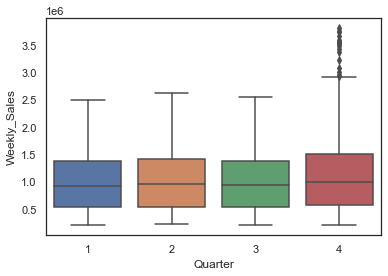

In [117]:
sns.boxplot(data=df, y='Weekly_Sales', x='Quarter')

`-` 4분기 매출액이 다른 분기에 비해 많다

<AxesSubplot:xlabel='Date', ylabel='Weekly_Sales'>

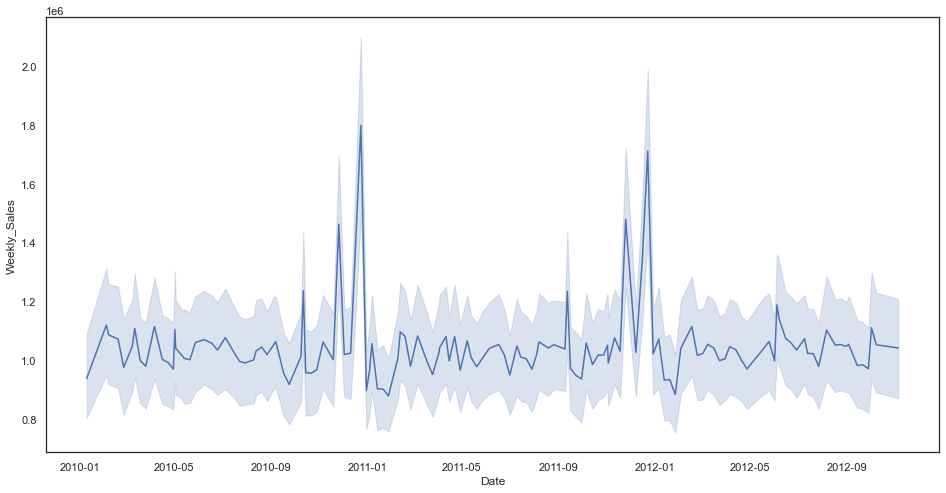

In [238]:
plt.figure(figsize=(16, 8))
sns.lineplot(data=df, x='Date', y='Weekly_Sales')

`-` 매출액의 추세를 보기위해 날짜에 따른 매출액을 시각화했다

`-` 라인플랏을 보면 12월에 쇼핑몰의 매출액이 확연히 증가하는 것을 알 수 있다

`-` 12월달에 고점이 2번 나타난 후에 크게 하락한다

`-` 12월달만 자세히 확인하자 

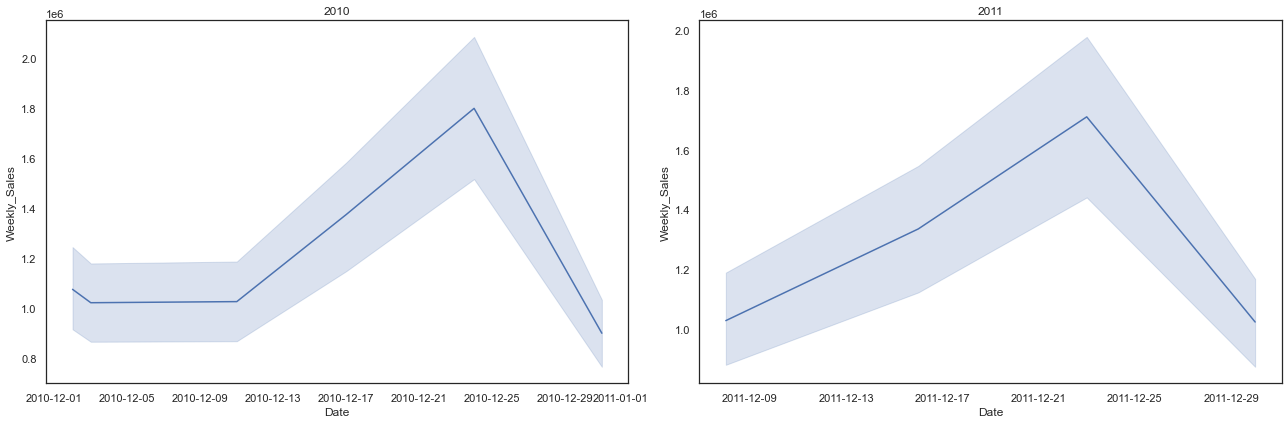

In [33]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
sns.lineplot(data=df.query('Year == 2010 and Month == 12'), x='Date', y='Weekly_Sales', ax=ax1)
sns.lineplot(data=df.query('Year == 2011 and Month == 12'), x='Date', y='Weekly_Sales', ax=ax2)
ax1.set_title('2010')
ax2.set_title('2011')
fig.tight_layout()

`-` 크리스마스 2주전부터 매출이 오르다가 크리스마스가 포함된 week에 고점을 찍고 원래의 매출로 돌아온다

`-` 한편, 위의 시계열 자료를 보면 주간 매출액이 올라갔다 내려갔다를 반복하고 있다

`-` 오차항에 상관관계가 있는지 임의의 쇼핑몰지점을 골라 확인하겠다

0.01348067687707123


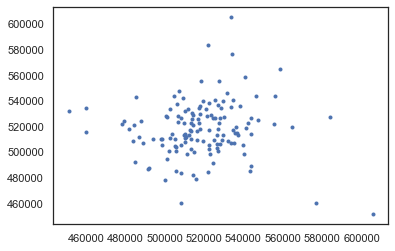

In [160]:
store = 37
store_sales = df.query('Store == @store').sort_values(by='Date')['Weekly_Sales']
current_time_sales = store_sales[:-1]
next_time_sales = store_sales[1:]
plt.plot(current_time_sales, next_time_sales, '.')
print(np.corrcoef(current_time_sales, next_time_sales)[1, 0])

`-` 이상점을 제외하면 오차항에 상관관계는 없어보인다

0.7989954398996255


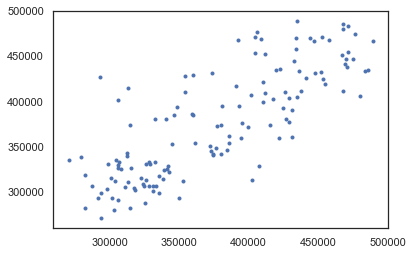

In [161]:
store = 36
store_sales = df.query('Store == @store').sort_values(by='Date')['Weekly_Sales']
current_time_sales = store_sales[:-1]
next_time_sales = store_sales[1:]
plt.plot(current_time_sales, next_time_sales, '.')
print(np.corrcoef(current_time_sales, next_time_sales)[1, 0])

`-` 오차항에 상관관계가 존재하는 쇼핑몰 지점도 존재한다

<AxesSubplot:xlabel='Store', ylabel='Weekly_Sales'>

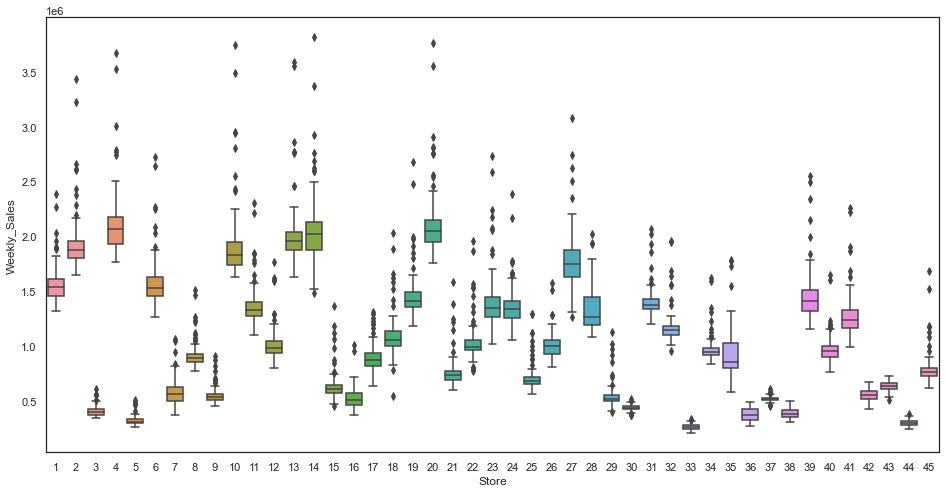

In [229]:
plt.figure(figsize=(16, 8))
sns.boxplot(data=df, y='Weekly_Sales', x='Store')

`-` 쇼핑몰 지점에 따라 매출액이 상이하다

`-` 매출액이 평균적으로 높은 경우 분산도 큰 경향이 있다 (반대로 매출액이 적은 경우 분산이 작다)

`-` 매출액이 비슷한 쇼핑몰끼리 묶어서 새로운 파생변수를 만들면 예측에 효과적일 것 같다

`-` 매출액이 적은 경우 분산도 작아 예측하기 쉽지만 매출액이 큰 경우는 분산이 크므로 정확한 예측을 위해 쇼핑몰 지점외의 다른 변수가 필요하다

`-` 각 박스플랏에서 이상점의 개수가 비슷해보인다

`-` 위의 박스플랏에서의 이상점은 연말에 사람들이 구매를 많이 하여 나타난 것으로 추정된다

<AxesSubplot:xlabel='Month', ylabel='Weekly_Sales'>

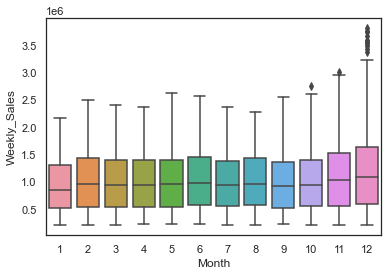

In [267]:
sns.boxplot(data=df, y='Weekly_Sales', x='Month')

`-` 11월과 12월에 매출액이 평균적으로 더 높다

`-` 1월에 매출액이 평균적으로 더 낮다

`-` 임의의로 쇼핑몰 지점을 골라 월별 매출액의 분포를 시각화하자

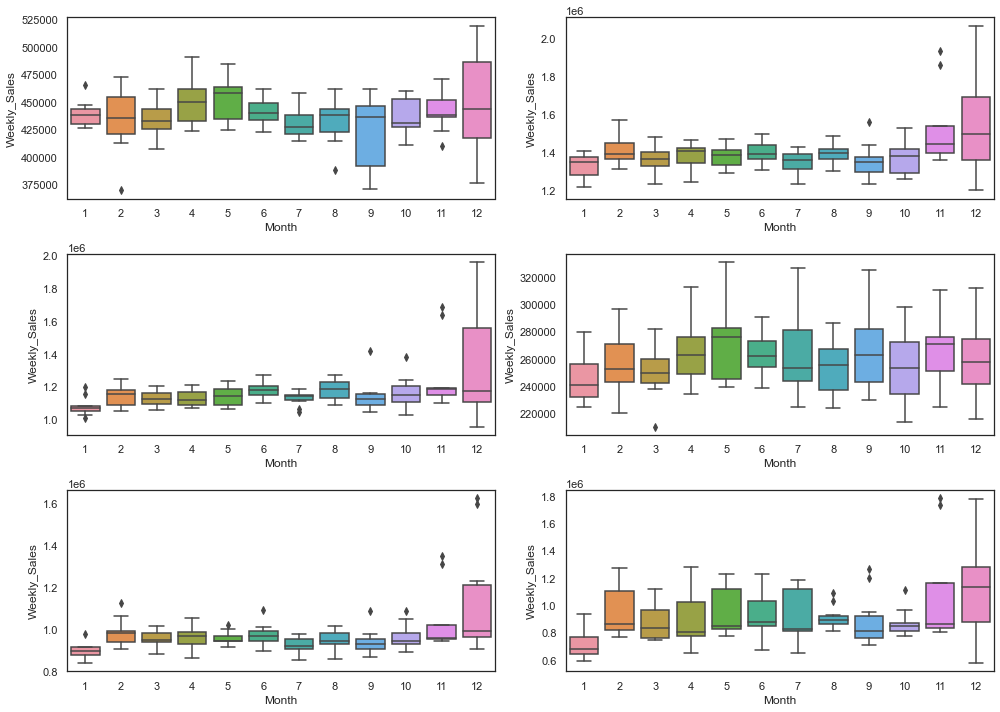

In [150]:
stores = list(range(30, 36))
fig, axs = plt.subplots(3, 2, figsize=(14, 10))
for i, ax in enumerate(axs.flatten()):
    sns.boxplot(data=df.query('Store == @stores[@i]'), y='Weekly_Sales', x='Month', ax=ax)
fig.tight_layout()

`-` 12월달에 매출액이 높고 분산이 크다

`-` 돈을 많이 사용했는지 1월달에는 매출액이 더 적은 편이다

- 쇼핑몰 주변 기온

<AxesSubplot:xlabel='Temperature', ylabel='Count'>

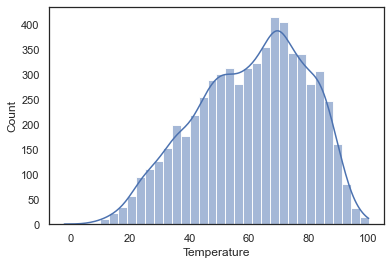

In [58]:
sns.histplot(data=df, x='Temperature', kde=True)

`-` 왼쪽으로 꼬리가 긴 분포이다

- 쇼핑몰 주변 연료 가격

<AxesSubplot:xlabel='Fuel_Price', ylabel='Count'>

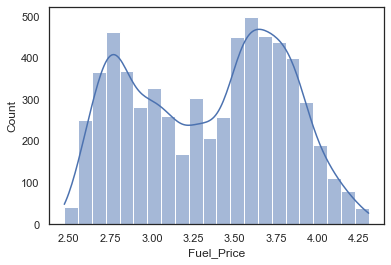

In [59]:
sns.histplot(data=df, x='Fuel_Price', kde=True)

`-` 양봉 분포이다

<AxesSubplot:xlabel='Fuel_Price', ylabel='Count'>

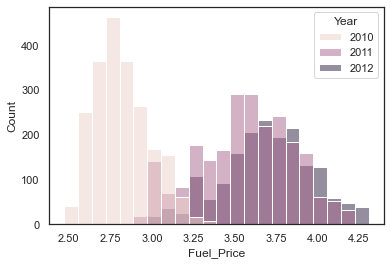

In [190]:
sns.histplot(data=df, x='Fuel_Price', hue='Year')

`-` 2010년인 경우와 아닌 경우 각각에 대해 분포가 형성되어 있다

`-` 2010년에 비해 2011년과 2012년의 연료 가격은 대략 1.4배이다

- 해당 쇼핑몰 지역의 실업률

<AxesSubplot:xlabel='Unemployment', ylabel='Count'>

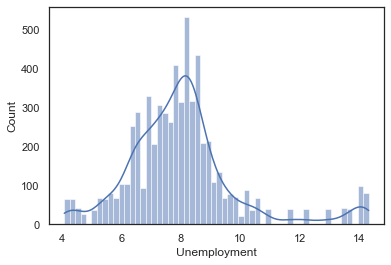

In [280]:
sns.histplot(data=df, x='Unemployment', kde=True) 

`-` 다른 쇼핑몰인데 동일한 날짜일 때의 실업률이 같다면 같은 지역이라 볼 수 있다

- 프로모션 정보

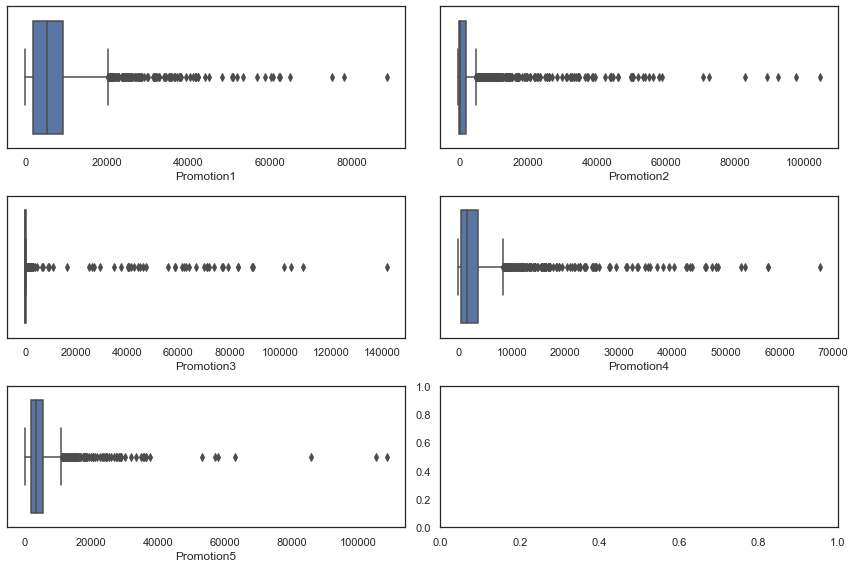

In [152]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, _)) = plt.subplots(3, 2, figsize=(12, 8))
sns.boxplot(data=df, x='Promotion1', ax=ax1)
sns.boxplot(data=df, x='Promotion2', ax=ax2)
sns.boxplot(data=df, x='Promotion3', ax=ax3)
sns.boxplot(data=df, x='Promotion4', ax=ax4)
sns.boxplot(data=df, x='Promotion5', ax=ax5)
fig.tight_layout()

`-` Promotion3를 제외하면 비슷한 분포로 보인다

`-` 결측치인 프로모션이 있으면 매출액이 더 낮은지 확인하자

In [173]:
na_promotion_idx = df.isnull().sum(axis=1) > 0 ## 프로모션에 결측치가 존재하는 인덱스

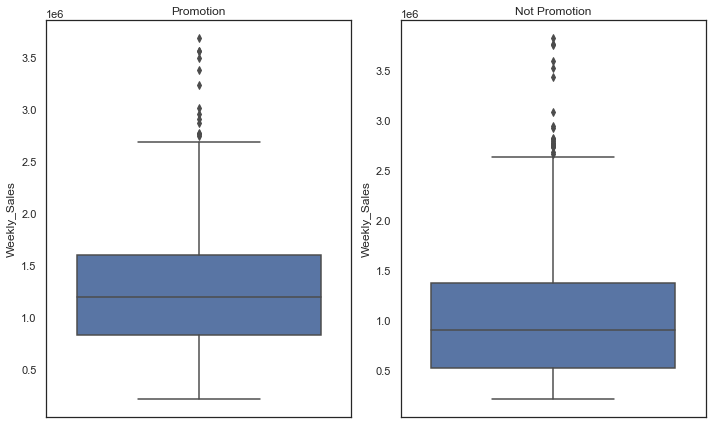

In [174]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
sns.boxplot(data=df[~na_promotion_idx], y='Weekly_Sales', ax=ax1)
sns.boxplot(data=df[na_promotion_idx], y='Weekly_Sales', ax=ax2)
ax1.set_title('Promotion')
ax2.set_title('Not Promotion')
fig.tight_layout()

`-` 결측치인 프로모션이 있는 경우 매출액의 중앙값이 더 적다

`-` 프로모션이 결측치여서 매출액이 적은건지 프로모션에 사용한 비용이 적어서 매출액이 적은건지 확인하자

In [179]:
df.fillna(value=-1, inplace=True)

In [184]:
df['Promotion_Cost'] = df[['Promotion1', 'Promotion2', 'Promotion3', 'Promotion4', 'Promotion5']].sum(axis=1)

<AxesSubplot:xlabel='Promotion_Cost', ylabel='Weekly_Sales'>

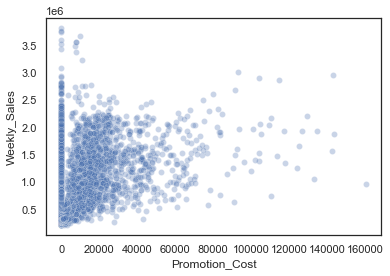

In [244]:
sns.scatterplot(data=df, x='Promotion_Cost', y='Weekly_Sales', alpha=0.3)

`-` 프로모션 비용과 매출액은 양의 상관관계가 있는 것으로 보인다

- 2010년으로부터 지난 일수

`-` 지점마다 분포가 상이하다

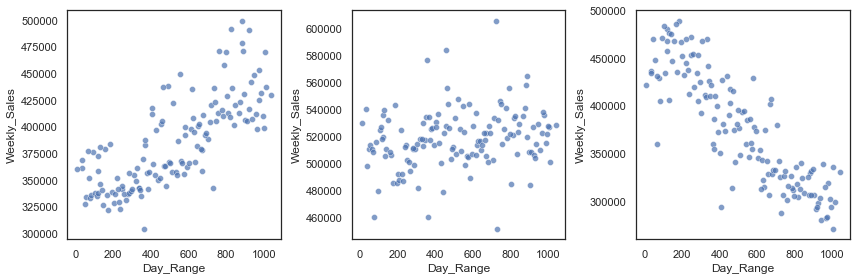

In [360]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
sns.scatterplot(data=df.query('Store == 38'), x='Day_Range', y='Weekly_Sales', alpha=0.7, ax=ax1)
sns.scatterplot(data=df.query('Store == 37'), x='Day_Range', y='Weekly_Sales', alpha=0.7, ax=ax2)
sns.scatterplot(data=df.query('Store == 36'), x='Day_Range', y='Weekly_Sales', alpha=0.7, ax=ax3)
fig.tight_layout()

`-` 위의 쇼핑몰 지점 모두 매출액의 분포가 비슷했는데 월별로 매출액이 상이하다

`-` 단순히 매출액만 비교하여 같은 카테고리로 묶는다면 정보의 손실을 불러올 수 있다

`-` 지난 일수외에도 연료 가격의 경우 위와 같은 산점도를 보인다

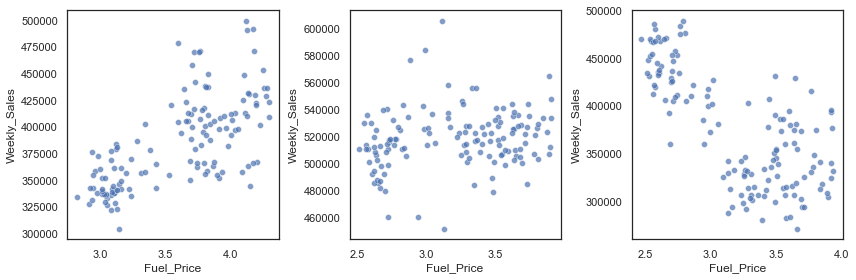

In [342]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
sns.scatterplot(data=df.query('Store == 38'), x='Fuel_Price', y='Weekly_Sales', alpha=0.7, ax=ax1)
sns.scatterplot(data=df.query('Store == 37'), x='Fuel_Price', y='Weekly_Sales', alpha=0.7, ax=ax2)
sns.scatterplot(data=df.query('Store == 36'), x='Fuel_Price', y='Weekly_Sales', alpha=0.7, ax=ax3)
fig.tight_layout()

`-` 실업률의 경우 위와 반대의 산점도를 띈다

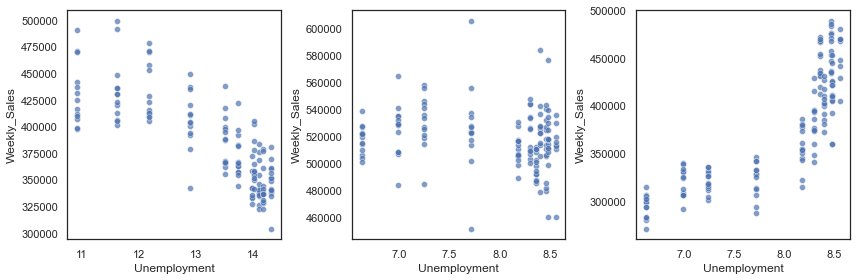

In [343]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
sns.scatterplot(data=df.query('Store == 38'), x='Unemployment', y='Weekly_Sales', alpha=0.7, ax=ax1)
sns.scatterplot(data=df.query('Store == 37'), x='Unemployment', y='Weekly_Sales', alpha=0.7, ax=ax2)
sns.scatterplot(data=df.query('Store == 36'), x='Unemployment', y='Weekly_Sales', alpha=0.7, ax=ax3)
fig.tight_layout()

`-` 모델링을 할 때 쇼핑몰 지점을 유사한 것끼리 묶는다면 매출액뿐만 아니라 지난 일수와 같은 변수를 사용하여 군집화해야 한다

`-` 지난 일수, 연료 가격, 실업률 중에서 지난 일수의 분포가 분산이 가장 작으므로 쇼핑몰 지점을 군집화 하는데 지난 일수를 사용하면 효과적일 것이다

- 상관계수 히트맵

In [220]:
features = ['Temperature', 'Fuel_Price', 'Unemployment', 'Day_Range', 'Promotion_Cost', 'Weekly_Sales']

Text(0.5, 1.0, 'Correlation between features')

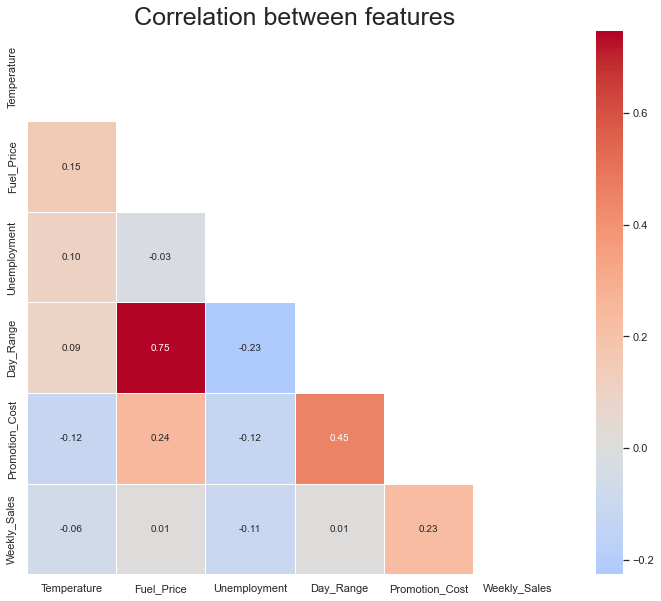

In [223]:
df_corr = df[features]
corr = df_corr.corr(method='pearson')
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(12, 10))
sns.heatmap(data = corr, mask=mask, annot=True, center=0, fmt='.2f', linewidths=.5, cmap='coolwarm')
plt.title('Correlation between features', fontsize=25)

`-` 프로모션 비용을 제외하면 매출액과 상관관계는 없다 

`-` 연료 가격과 날짜 사이에 강한 양의 상관관계가 있다